In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Portfolio Optimization Library
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting


In [2]:
# Setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
FIGURES_PATH = '../reports/figures/'

# Load Historical and Forecasted Data
try:
    # Historical daily returns for all assets (from Task 1)
    daily_returns = pd.read_csv('../data/processed/daily_returns.csv', index_col='Date', parse_dates=True)
    
    # Historical closing prices (to get the last price of TSLA)
    close_prices = pd.read_csv('../data/processed/close_prices.csv', index_col='Date', parse_dates=True)
    mean_forecast = np.load('../models/lstm_mean_forecast.npy') 

    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure all required data files from previous tasks exist.")
    exit()

Data loaded successfully.


In [3]:
# Calculate Expected Return for TSLA from LSTM Forecast
last_known_price_tsla = close_prices['TSLA'].iloc[-1]
final_forecast_price_tsla = mean_forecast[-1]

# Calculate the expected annual return for TSLA
exp_return_tsla = (final_forecast_price_tsla / last_known_price_tsla) - 1

print(f"Last known TSLA price: ${last_known_price_tsla:.2f}")
print(f"Final forecasted TSLA price (1-year): ${final_forecast_price_tsla:.2f}")
print(f"Forecasted Annual Return for TSLA: {exp_return_tsla:.2%}")

# Calculate Expected Returns for BND & SPY from Historical Data 
mu_historical = expected_returns.mean_historical_return(close_prices[['BND', 'SPY']])

# Combine into a single Expected Returns vector
mu = pd.Series({
    'TSLA': exp_return_tsla,
    'BND': mu_historical['BND'],
    'SPY': mu_historical['SPY']
})

print("\n--- Combined Expected Annual Returns for Portfolio Optimization ---")
print(mu)

Last known TSLA price: $319.04
Final forecasted TSLA price (1-year): $381.48
Forecasted Annual Return for TSLA: 19.57%

--- Combined Expected Annual Returns for Portfolio Optimization ---
TSLA    0.195702
BND     0.018252
SPY     0.136706
dtype: float64


In [9]:
S = risk_models.sample_cov(close_prices)
print("\n--- Covariance Matrix ---")
print(S)


--- Covariance Matrix ---
           BND       SPY      TSLA
BND   0.003016  0.001150  0.001861
SPY   0.001150  0.033272  0.052950
TSLA  0.001861  0.052950  0.350331


In [10]:
# Instantiate the Efficient Frontier 
ef = EfficientFrontier(mu, S)

# Find the Minimum Volatility Portfolio
weights_min_vol = ef.min_volatility()
cleaned_weights_min_vol = ef.clean_weights()
print("\n--- Minimum Volatility Portfolio ---")
print(cleaned_weights_min_vol)
ef.portfolio_performance(verbose=True, risk_free_rate=0.02)

# Find the Maximum Sharpe Ratio Portfolio
ef = EfficientFrontier(mu, S) 
weights_max_sharpe = ef.max_sharpe(risk_free_rate=0.02)
cleaned_weights_max_sharpe = ef.clean_weights()
print("\n--- Maximum Sharpe Ratio Portfolio ---")
print(cleaned_weights_max_sharpe)
max_sharpe_perf = ef.portfolio_performance(verbose=True, risk_free_rate=0.02)


--- Minimum Volatility Portfolio ---
OrderedDict([('TSLA', 0.94511), ('BND', 0.05489), ('SPY', 0.0)])
Expected annual return: 18.6%
Annual volatility: 5.4%
Sharpe Ratio: 3.07

--- Maximum Sharpe Ratio Portfolio ---
OrderedDict([('TSLA', 0.99959), ('BND', 0.0), ('SPY', 0.00041)])
Expected annual return: 19.6%
Annual volatility: 5.5%
Sharpe Ratio: 3.20



Efficient Frontier plot saved to: ../reports/figures/05_efficient_frontier.png


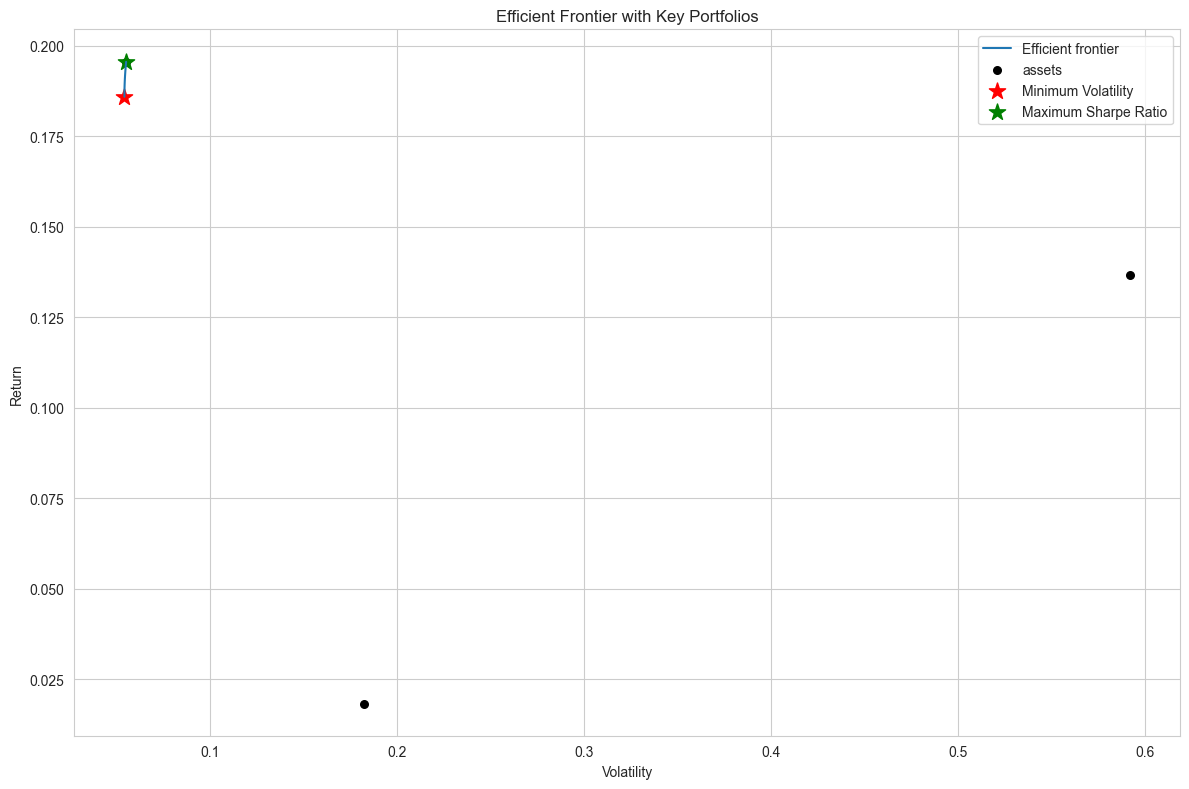

In [12]:
# Plot
ef_for_plotting = EfficientFrontier(mu, S)


fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_for_plotting, ax=ax, show_assets=True)
ef_min_vol = EfficientFrontier(mu, S)
ef_min_vol.min_volatility()
ret_min_vol, std_min_vol, _ = ef_min_vol.portfolio_performance(risk_free_rate=0.02, verbose=False)
ax.scatter(std_min_vol, ret_min_vol, marker="*", s=150, color="r", label="Minimum Volatility")

ef_max_sharpe = EfficientFrontier(mu, S)
ef_max_sharpe.max_sharpe(risk_free_rate=0.02)
ret_max_sharpe, std_max_sharpe, _ = ef_max_sharpe.portfolio_performance(risk_free_rate=0.02, verbose=False)
ax.scatter(std_max_sharpe, ret_max_sharpe, marker="*", s=150, color="g", label="Maximum Sharpe Ratio")

# Final plot adjustments
ax.set_title("Efficient Frontier with Key Portfolios")
ax.legend()
plt.tight_layout()

plt.savefig(os.path.join(FIGURES_PATH, '05_efficient_frontier.png'), dpi=300)
print(f"\nEfficient Frontier plot saved to: {os.path.join(FIGURES_PATH, '05_efficient_frontier.png')}")
plt.show()

In [13]:
# Final Recommended Portfolio Summary 
print("\n" + "="*50)
print("   FINAL PORTFOLIO RECOMMENDATION FOR GMF INVESTMENTS")
print("="*50)
print("Strategy: Maximum Sharpe Ratio (Best Risk-Adjusted Return)")
print("\nThis portfolio is recommended as it offers the most efficient balance between risk and our forecast-driven expected return.")
print("\n--- Optimal Asset Weights ---")
for asset, weight in cleaned_weights_max_sharpe.items():
    print(f"{asset}: {weight:.2%}")

print("\n--- Portfolio Performance Metrics ---")
expected_return, volatility, sharpe_ratio = max_sharpe_perf
print(f"Expected Annual Return: {expected_return:.2%}")
print(f"Annual Volatility (Risk): {volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print("="*50)


   FINAL PORTFOLIO RECOMMENDATION FOR GMF INVESTMENTS
Strategy: Maximum Sharpe Ratio (Best Risk-Adjusted Return)

This portfolio is recommended as it offers the most efficient balance between risk and our forecast-driven expected return.

--- Optimal Asset Weights ---
TSLA: 99.96%
BND: 0.00%
SPY: 0.04%

--- Portfolio Performance Metrics ---
Expected Annual Return: 19.57%
Annual Volatility (Risk): 5.49%
Sharpe Ratio: 3.20
